In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import seaborn as sns

In [2]:

ground_truths = np.load("results/ground_truths.npy")
baseline_samples = np.load("results/samples_20251114_160406_best_val.npy")
cold_samples = np.load("results/samples_20251114_160406_best_val_cold.npy")
# baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
# baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
# baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
# model_predictions = model_predictions[:baseline_predictions.shape[0]]
# model_samples = model_samples[:baseline_predictions.shape[0]]


In [4]:
baseline_samples.shape, cold_samples.shape, ground_truths.shape

((412, 10, 12, 275), (412, 10, 12, 275), (412, 12, 275))

In [5]:
def to_STN(arr):
    """
    将 (B, S, T, N) 转成 (S_total, T, N)
    """
    if arr.ndim != 4:
        raise ValueError("输入应为 4D: (B, S, T, N)")

    B, S, T, N = arr.shape
    arr2 = arr.reshape(B*S, T, N)
    return arr2

In [6]:
# -------------- 转换为 (S_total, T, N) ---------------
baseline = to_STN(baseline_samples)  # (S_total, T, N)
cold     = to_STN(cold_samples)

S_total, T, N = baseline.shape

# =========================================
# 1. Mean
# =========================================
mean_base = baseline.mean(axis=0)   # (T, N)
mean_cold = cold.mean(axis=0)
delta_mean = mean_cold - mean_base  # (T, N)

# =========================================
# 2. Std
# =========================================
std_base = baseline.std(axis=0)
std_cold = cold.std(axis=0)
delta_std = std_cold - std_base     # (T, N)

# =========================================
# 3. Peak probability: P(x > threshold)
# =========================================
threshold = 0.8

peak_prob_base = (baseline > threshold).mean(axis=0)  # (T, N)
peak_prob_cold = (cold > threshold).mean(axis=0)
delta_peak_prob = peak_prob_cold - peak_prob_base

# =========================================
# 4. Spatial entropy
# =========================================
def spatial_entropy(x):
    p = x / x.sum()
    p = np.clip(p, 1e-8, 1)
    return -(p * np.log(p)).sum()

entropy_base = np.array([spatial_entropy(mean_base[t]) for t in range(T)])
entropy_cold = np.array([spatial_entropy(mean_cold[t]) for t in range(T)])
delta_entropy = entropy_cold - entropy_base


In [9]:
import geopandas as gpd
# 读取shp文件
shp = gpd.read_file("urbanev/SZ_districts/SZ_districts.shp")
shp_ids = set(shp["TAZID"].unique())

# 读取csv文件
csv = pd.read_csv("urbanev/inf.csv")
csv_ids = set(csv["TAZID"].unique())

# 检查是否都包含
missing_ids = csv_ids - shp_ids

if len(missing_ids) == 0:
    print("✅ inf.csv 中的 TAZID 全部包含在 shp 文件中")
else:
    print("⚠ 有缺失的 TAZID：", missing_ids)


# 在 shp 中新增一列，存在则标记为 1，否则为 0
shp["in_csv"] = shp["TAZID"].apply(lambda x: 1 if x in csv_ids else 0)

✅ inf.csv 中的 TAZID 全部包含在 shp 文件中


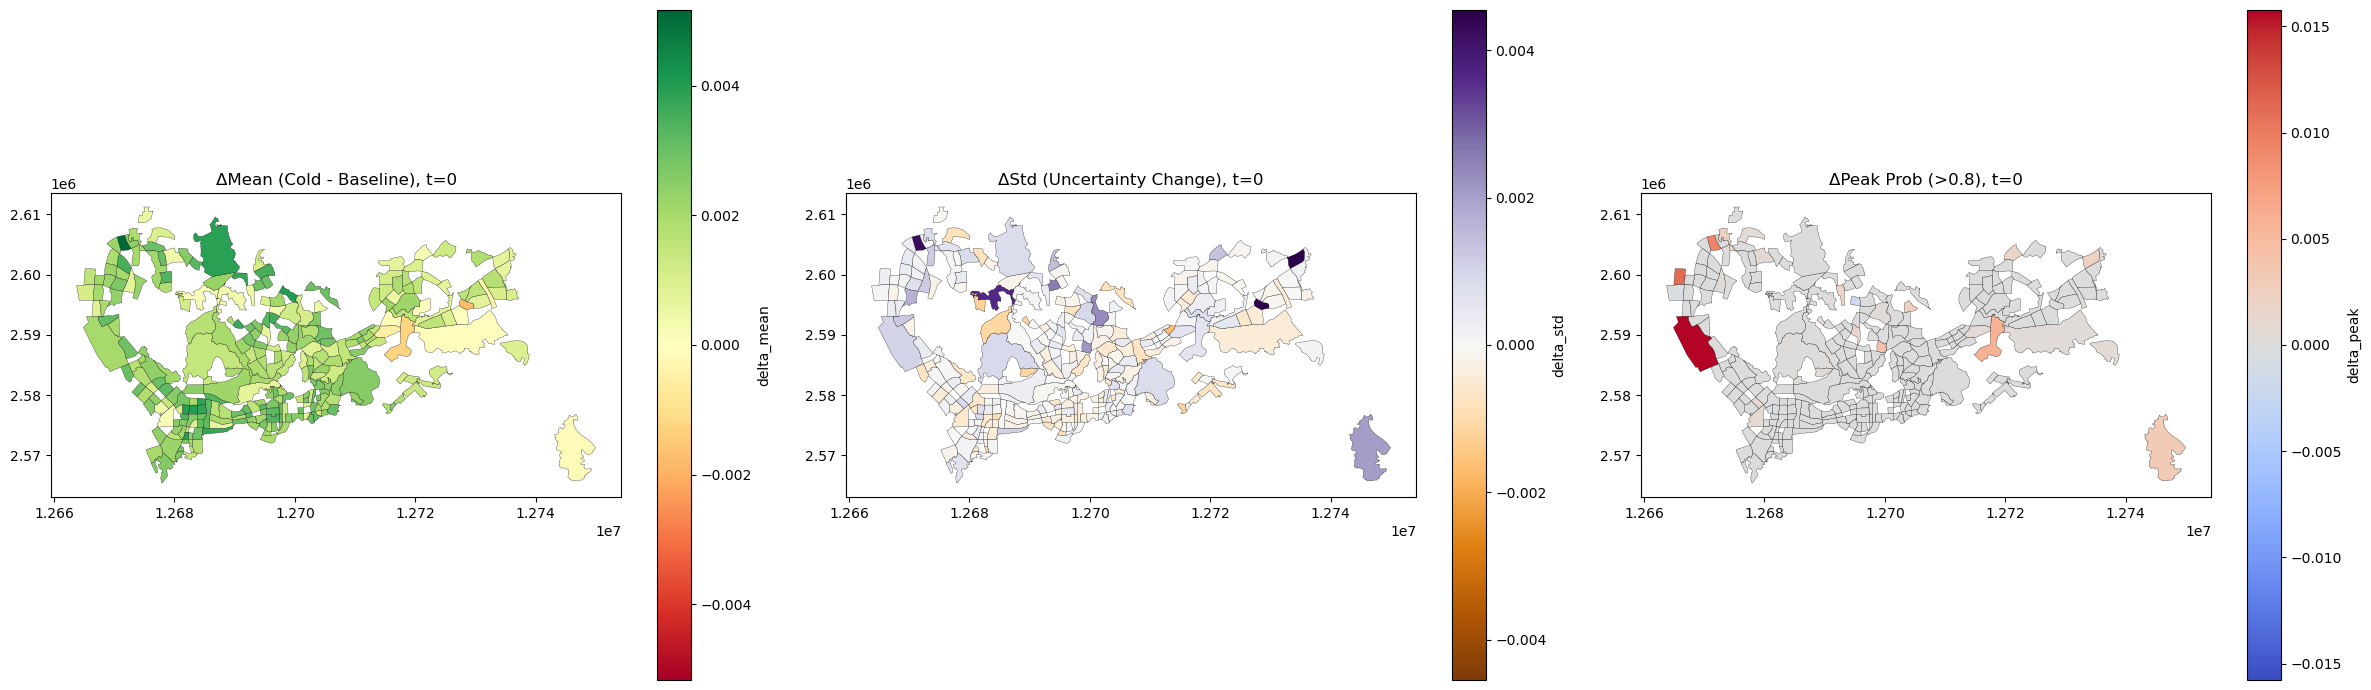

In [41]:
import geopandas as gpd
import matplotlib.pyplot as plt

t = 0  # 展示第1个未来时间步

shp_plot = shp[shp["in_csv"] == 1].copy()
shp_plot = shp_plot.sort_values("TAZID").reset_index(drop=True)

shp_plot["delta_mean"] = delta_mean[t]
shp_plot["delta_std"] = delta_std[t]
shp_plot["delta_peak"] = delta_peak_prob[t]

# ---------------------------
# 自定义函数：以 0 为中心的 colorbar
# ---------------------------
def plot_centered(shp_df, column, title, ax, cmap):
    data = shp_df[column].values
    vmax = np.max(np.abs(data))
    vmin = -vmax

    # 绘制地图
    shp_df.plot(column=column, cmap=cmap, vmin=vmin, vmax=vmax,
                linewidth=0.2, edgecolor="black", ax=ax)

    ax.set_title(title)

    # 加 colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []  # 必需，否则 colorbar 报错
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(column)


# ---------------------------
# 绘制三幅图
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

plot_centered(
    shp_plot, "delta_mean",
    f"ΔMean (Cold - Baseline), t={t}", axes[0],
    cmap="RdYlGn"
)

plot_centered(
    shp_plot, "delta_std",
    f"ΔStd (Uncertainty Change), t={t}", axes[1],
    cmap="PuOr"
)

plot_centered(
    shp_plot, "delta_peak",
    f"ΔPeak Prob (>0.8), t={t}", axes[2],
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


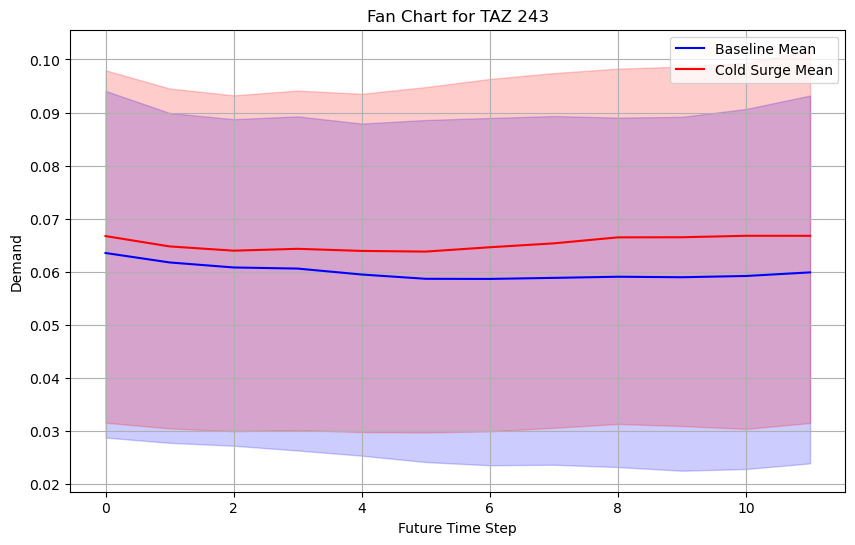

In [46]:
TAZ = 243

base_mean = mean_base[:, TAZ]
base_p5 = np.percentile(baseline[:, :, TAZ], 5, axis=0)
base_p95 = np.percentile(baseline[:, :, TAZ], 95, axis=0)

cold_mean = mean_cold[:, TAZ]
cold_p5 = np.percentile(cold[:, :, TAZ], 5, axis=0)
cold_p95 = np.percentile(cold[:, :, TAZ], 95, axis=0)

plt.figure(figsize=(10,6))

plt.plot(base_mean, label="Baseline Mean", color="blue")
plt.fill_between(range(T), base_p5, base_p95, color="blue", alpha=0.2)

plt.plot(cold_mean, label="Cold Surge Mean", color="red")
plt.fill_between(range(T), cold_p5, cold_p95, color="red", alpha=0.2)

plt.xlabel("Future Time Step")
plt.ylabel("Demand")
plt.title(f"Fan Chart for TAZ {TAZ}")
plt.grid(True)
plt.legend()
plt.show()


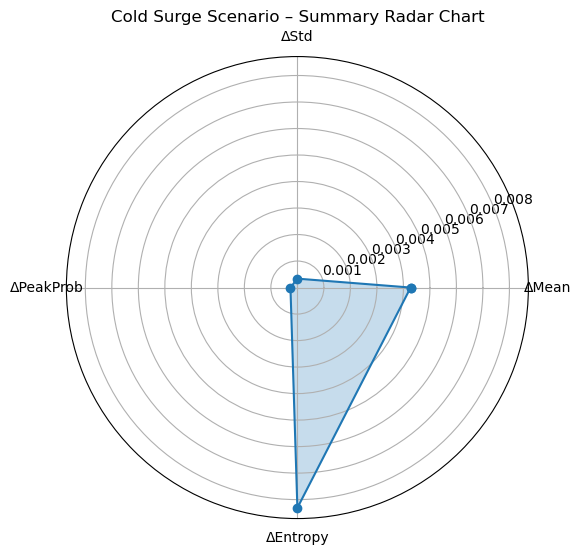

In [15]:

mean_change_global = delta_mean.mean()
std_change_global = delta_std.mean()
peak_prob_global = delta_peak_prob.mean()
entropy_change_global = delta_entropy.mean()

labels = ["ΔMean", "ΔStd", "ΔPeakProb", "ΔEntropy"]
values = [mean_change_global, std_change_global, peak_prob_global, entropy_change_global]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
values = np.concatenate([values, [values[0]]])
angles = np.concatenate([angles, [angles[0]]])

plt.figure(figsize=(6,6))
plt.polar(angles, values, marker="o")
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], labels)
plt.title("Cold Surge Scenario – Summary Radar Chart")
plt.show()


In [23]:
from scipy.stats import ks_2samp

baseline_STN = to_STN(baseline_samples)
cold_STN     = to_STN(cold_samples)

def ks_test_for_taz_time(t, taz):
    base = baseline_STN[:, t, taz]
    cold = cold_STN[:, t, taz]

    stat, p = ks_2samp(base, cold)
    return stat, p

# Example: TAZ 10, time step 3
stat, p = ks_test_for_taz_time(t=3, taz=10)
print("KS stat =", stat, "p-value =", p)


KS stat = 0.10800970873786407 p-value = 2.447550985281837e-21


In [28]:
import esda
import libpysal
import numpy as np

# Step 1: 创建空间权重（基于 TAZ 邻接）
# shp 是 geopandas 的 GeoDataFrame
shp=shp[shp["in_csv"] == 1].copy()
w = libpysal.weights.contiguity.Queen.from_dataframe(shp)

# Step 2: 选择变量（例如 ΔMean at t=0）
y = delta_mean[0]    # shape (N,)

# Step 3: 计算 Moran's I
mi = esda.Moran(y, w)
print("Moran's I:", mi.I, "p-value:", mi.p_sim)


('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 79, ' is an island (no neighbors)')
('WARNING: ', 128, ' is an island (no neighbors)')
('WARNING: ', 227, ' is an island (no neighbors)')
Moran's I: 0.10366068762621199 p-value: 0.007


c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\libpysal\weights\_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\libpysal\weights\_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
 There are 7 islands with ids: 6, 12, 18, 42, 79, 128, 227.
  warnings.warn(message)


In [34]:
import numpy as np
import geopandas as gpd
from libpysal.weights import KNN
from esda import Moran_Local

# 1. 计算每个 TAZ 的几何质心
shp_plot["centroid_x"] = shp_plot.geometry.centroid.x
shp_plot["centroid_y"] = shp_plot.geometry.centroid.y

# 2. 构建点坐标矩阵
coords = np.column_stack((shp_plot["centroid_x"], shp_plot["centroid_y"]))

# 3. 用质心构建 KNN 空间权重（不会出现孤立区域）
w = KNN.from_array(coords, k=4)   # 注意这里是 from_array，而不是 from_dataframe
w.transform = "r"

# 4. LISA 示例
y = delta_mean[0]   # (N,)

lisa = Moran_Local(y, w)

print("OK! LISA computed successfully.")
print("p-values:", lisa.p_sim[:10])
print("clusters:", lisa.q[:10])


OK! LISA computed successfully.
p-values: [0.017 0.38  0.467 0.085 0.473 0.208 0.217 0.288 0.107 0.266]
clusters: [2 4 1 2 1 2 2 4 1 1]


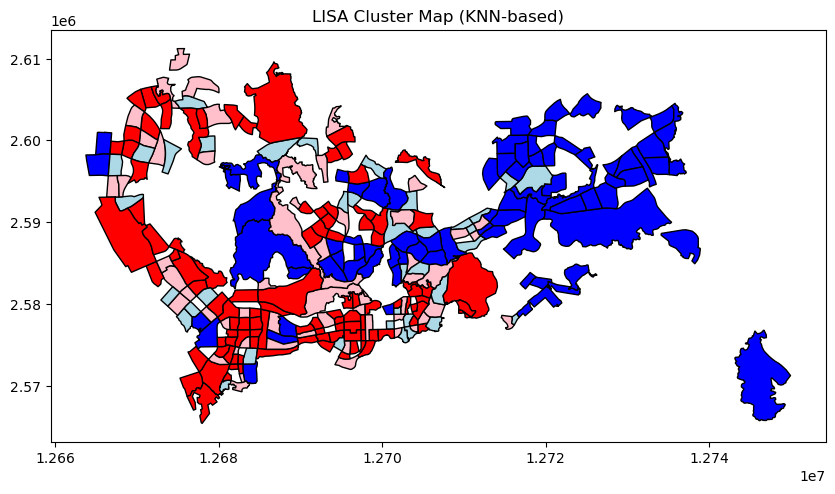

In [35]:
import matplotlib.pyplot as plt

shp_plot["LISA_cluster"] = lisa.q

cmap = {
    1: "red",      # HH
    2: "pink",     # LH
    3: "blue",     # LL
    4: "lightblue" # HL
}

shp_plot["color"] = shp_plot["LISA_cluster"].map(cmap)

fig, ax = plt.subplots(figsize=(10,8))
shp_plot.plot(color=shp_plot["color"], edgecolor="black", ax=ax)
plt.title("LISA Cluster Map (KNN-based)")
plt.show()


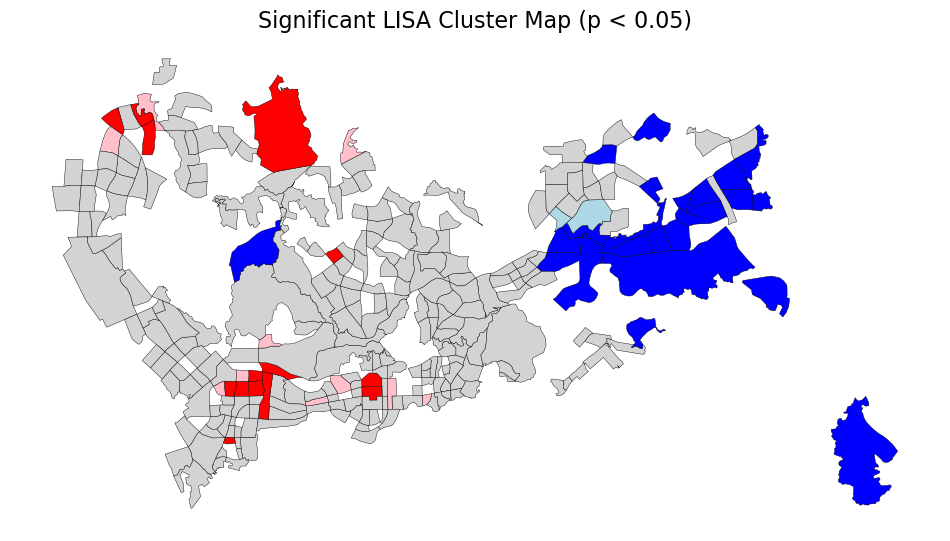

In [36]:
pvals = lisa.p_sim
clusters = lisa.q 
significant = pvals < 0.05   # True = 显著
shp_sig = shp_plot.copy()
shp_sig["cluster"] = clusters
shp_sig["significant"] = significant

# 对不显著区域标记为 0（表示灰色）
shp_sig.loc[~shp_sig["significant"], "cluster"] = 0
# 自定义颜色映射
cmap = {
    0: "lightgrey",   # 不显著区域
    1: "red",         # High-High
    2: "pink",        # Low-High
    3: "blue",        # Low-Low
    4: "lightblue"    # High-Low
}

shp_sig["color"] = shp_sig["cluster"].map(cmap)

# 绘图
fig, ax = plt.subplots(figsize=(12, 8))
shp_sig.plot(color=shp_sig["color"], edgecolor="black", linewidth=0.3, ax=ax)

plt.title("Significant LISA Cluster Map (p < 0.05)", fontsize=16)
plt.axis("off")
plt.show()